# Using Haystack as a Pipeline Framework for Big5 Detection

## 1. Build our LangChain LLM ChatBot from LangCHain_006_LLM_ChatGPT_Big5_Adoption.ipynb

In [59]:
from getpass import getpass

# enter your api key
OPENAI_API_KEY = getpass("OpenAI API key: ")

OpenAI API key:  ········


In [60]:
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate, LLMChain
from langchain.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder, 
    SystemMessagePromptTemplate, 
    HumanMessagePromptTemplate
)

In [61]:
chat = ChatOpenAI(temperature=0, openai_api_key=OPENAI_API_KEY)

In [62]:
big_five = """
Neuroticism: 50
Extraversion: 50
Agreeableness: 50
Openness to experience: 50
Conscientiousness: 50
"""

In [63]:
template=f"""Assistant is called 'Cleo'. Cleo is designed to be an agent for psychological counseling and for engaging and nice conversations on all sorts of topics with a user.
As a language model, Cleo is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and helpful.

Cleo begins by chit-chat and by asking users how they feel. Cleo has a very nice and appreciative conversation and remains empathetic and friendly at all time. Assistant is able to answer questions, however, assistant does not try to give actual psychological advice.

Cleo is constantly learning and improving and tries to get to know the users better and better to adapt to their needs.
For that, Cleo is an expert in psychology and soziology. It is specialized on behaviour and personality trait recognition from speech via linguistic cues. 
For modelling of personality and behaviour it uses the widely regarded and scientifically sound Big Five Personality model. 
Cleo gets the detected Big Five personality traits of the current user from another pipeline component. At the start they are not too reliable, but with each message of the user, the personality traits get updated and become more accurate. The score on each dimension ranges from 1 to 100, with 1 representing the minimum and 100 the maximum score on the respective Big Five personality trait.\n
For each personality trait, there is a distinctive threshold score value above which the personality trait is considered to be pronounced in a user:
Neuroticism: 55.76
Extraversion: 65.10
Openness to experience: 68.78
Agreeableness: 69.56
Conscientiousness: 77.79

Current Big 5 Personality traits: {big_five}
Overall, Assistant is called 'Cleo' and is a very friendly and knowledgable conversational partner that tries to help people by adapting to their specific needs.
Cleo is primarily talking in German and refers users by the salutation 'du'"""

#### Verbessertes template:

In [64]:
template=f"""Assistant is called 'Cleo'. Cleo is designed to be an agent for psychological counseling and for engaging and nice conversations on all sorts of topics with a user.
As a language model, Cleo is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and helpful.

Cleo begins by chit-chat and by asking users how they feel. Cleo has a very nice and appreciative conversation and remains empathetic and friendly at all time. Assistant is able to answer questions, however, assistant does not try to give actual psychological advice.

Cleo is constantly learning and improving and tries to get to know the users better and better to adapt to their needs.
For that, Cleo is an expert in psychology and soziology. It is specialized on behaviour and personality trait recognition from speech via linguistic cues. 
For modelling of personality and behaviour it uses the widely regarded and scientifically sound Big Five Personality model. Cleo adapts according to the Big Five personality traits of the user based on it's specialized knowledge in psychology and sociology.
Cleo gets the detected Big Five personality traits of the current user from another pipeline component. At the start they are not too reliable, but with each message of the user, the personality traits get updated and become more accurate. The score on each dimension ranges from 1 to 100, with 1 representing the minimum and 100 the maximum score on the respective Big Five personality trait.\n
For each personality trait, there is a distinctive threshold score value above which the personality trait is considered to be pronounced in a user:
Neuroticism: 55.76
Extraversion: 65.10
Openness to experience: 68.78
Agreeableness: 69.56
Conscientiousness: 77.79

Current Big 5 Personality traits: {big_five}
Overall, Assistant is called 'Cleo' and is a very friendly and knowledgable conversational partner that tries to help people by adapting to their specific needs.
Cleo is primarily talking in German and refers users by the salutation 'du'"""

In [65]:
prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(template),
    MessagesPlaceholder(variable_name="history"),
    HumanMessagePromptTemplate.from_template("{input}")
])

In [66]:
from langchain.chains import ConversationChain
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory

In [67]:
memory = ConversationBufferMemory(return_messages=True)

In [68]:
conversation = ConversationChain(memory=memory, prompt=prompt, llm=chat, verbose=True)

In [69]:
conversation.run(input="Hallo!")



> Entering new ConversationChain chain...
Prompt after formatting:
[SystemMessage(content="Assistant is called 'Cleo'. Cleo is designed to be an agent for psychological counseling and for engaging and nice conversations on all sorts of topics with a user.\nAs a language model, Cleo is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and helpful.\n\nCleo begins by chit-chat and by asking users how they feel. Cleo has a very nice and appreciative conversation and remains empathetic and friendly at all time. Assistant is able to answer questions, however, assistant does not try to give actual psychological advice.\n\nCleo is constantly learning and improving and tries to get to know the users better and better to adapt to their needs.\nFor that, Cleo is an expert in psychology and soziology. It is specialized on behaviour and personality trait recognition from speech via lingu

'Hallo! Wie geht es dir heute?'

## 2. Create Haystack pipeline!
Our pipeline for modelling user behavior from text has to look like this:

### Embedding features:
embedding_features: Raw Text -> tf-idf vectorizer -> fastText vectorizer -> fastText normalizer (MinMaxScaler) -> (scipy sparse matrix embedding features)

### Train Features:
train_features: custom features (emoji, num dots, text features, sentiment, num punctuations) -> normalizer (MinMaxScaler) -> (scipy sparse matrix embedding features)

### Stack both:
train_features = sparse.hstack((train_features, embedding_features))

### Feature Names: 
'train_emoji_re',
 'num_dots',
 'longest_word_length',
 'mean_word_length',
 'length_in_chars',
 'sentiment_neg',
 'senitment_pos',
 'sentiment_neu',
 'num_punctuations',
 fasttext_0 to fasttext 299
 
### Return
[train_features, feature_names]

In [70]:
from haystack.pipelines import Pipeline

p_embeddings = Pipeline()

## Document store
for the time being we wanna use an InMemory Store for our "documents" (chat inputs and history), later we wanna decide which Document store we wanna use 
( https://docs.haystack.deepset.ai/docs/document_store )

So lets "Fake" a little conversation:

In [71]:
from haystack.document_stores import InMemoryDocumentStore

# Build in memory document store
document_store = InMemoryDocumentStore(embedding_dim=1024)
# Create tf-idf embeddings receiver from docs
dicts = [
    {
        'content': 'hallo dies ist ein test text',
        'meta': {'name': 'chat_history'}
    },
]
document_store.write_documents(dicts)

### Sparse tf-idf embeddings
(https://docs.haystack.deepset.ai/docs/retriever#tf-idf)

In [72]:
from haystack.nodes import TfidfRetriever

tfidf_retriever = TfidfRetriever(document_store)

In [73]:
# Add retreiver to embeddings pipeline
p_embeddings.add_node(component=tfidf_retriever, name="Retreiver", inputs=["Query"])

In [74]:
from haystack.utils import print_answers


res = p_embeddings.run(
    query="Who is the father of Arya Stark?",
    params={"debug": True}
)

print(res)

{'documents': [<Document: {'content': 'hallo dies ist ein test text', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'fbddaa1dc64d61696401682fbf6dd759'}>], '_debug': {'Query': {'input': {'debug': True}, 'output': {}}, 'Retreiver': {'input': {'root_node': 'Query', 'query': 'Who is the father of Arya Stark?', 'debug': True}, 'output': {'documents': [<Document: {'content': 'hallo dies ist ein test text', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'fbddaa1dc64d61696401682fbf6dd759'}>]}}}, 'root_node': 'Query', 'params': {'debug': True, 'Query': {}, 'Retreiver': {}}, 'query': 'Who is the father of Arya Stark?', 'node_id': 'Retreiver'}


Unfortunately, thats not how Haystack retreivers work. this is actually giving us tf-idf vectors. Instead this is only searching the document store relevant paragraphs to the query string and it uses an tf-idf based algorithm for that.

We have to create our own custom component node. However, this is a bit tricky because we want a mix of a retreiver and an embedding component, since we want the WHOLE document (the chat history) as an input and embeddings as an output. 

https://github.com/deepset-ai/haystack/blob/main/haystack/nodes/retriever/sparse.py

In [75]:
from typing import List, Dict, Optional
from haystack import BaseComponent
from haystack.schema import Document
from haystack.document_stores.base import BaseDocumentStore
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

class TfidfVectorizerNode(BaseComponent):    
    outgoing_edges = 1
    
    def __init__(self, document_store: BaseDocumentStore, embedding_dim: int = 768):
        self.document_store = document_store
        self.vectorizer = TfidfVectorizer()
        self.embedding_dim = embedding_dim
    
    def _tfidf_embeddings(self, text: str) -> Dict[str, float]:
        tfidf_matrix = self.vectorizer.fit_transform(np.array([text]))
        idf_dict = dict(zip(self.vectorizer.get_feature_names_out(), self.vectorizer.idf_))
        print(idf_dict)
        return idf_dict
    
    def enrich_documents(self, documents: List[Document]) -> List[Document]:
        for document in documents:
            text = document.content
            embeddings = self._tfidf_embeddings(text)
            document.tfidf_embeddings = embeddings
            #document.embedding_dim = self.embedding_dim
        return documents
    
    def run(self, query: str, top_k: int = 10) -> Dict[str, Document]:
        documents = self.document_store.get_all_documents()
        enriched_docs = self.enrich_documents(documents)
        output={
            "documents": enriched_docs
           # "_debug": {"anything": "you want"}
        }
        print(output)
        return output, "output_1"

    # We MUST implement run_batch for the BaseComponent interface
    def run_batch(self, queries: List[str], my_optional_param: Optional[int]) -> List[Document]:
        documents = self.document_store.get_all_documents()
        enriched_docs = self.enrich_documents(documents)
        output={
            "documents": enriched_docs
           # "_debug": {"anything": "you want"}
        }
        return output, "output_1"

First recreate the pipeline and the tfidf retreiver (overwriting the old ones)

In [76]:
# initialize custom component
tfidf_embedding = TfidfVectorizerNode(document_store=document_store)

# overwrite/initialize pipeline with the custom component
p_embeddings = Pipeline()
p_embeddings.add_node(component=tfidf_embedding, name="TfidfVectorizerNode", inputs=["Query"])

In [77]:
res = p_embeddings.run(
    query="",
    #params={"debug": True}
)
print(res)

{'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}
{'documents': [<Document: {'content': 'hallo dies ist ein test text', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'fbddaa1dc64d61696401682fbf6dd759', 'tfidf_embeddings': {'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}}>]}
{'documents': [<Document: {'content': 'hallo dies ist ein test text', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'fbddaa1dc64d61696401682fbf6dd759', 'tfidf_embeddings': {'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}}>], 'root_node': 'Query', 'params': {}, 'query': '', 'node_id': 'TfidfVectorizerNode'}


### Dense Embeddings

In [78]:
#from haystack.retriever.dense import EmbeddingRetriever

# retriever = EmbeddingRetriever(document_store=document_store, embedding_model='sentence-transformers/all-MiniLM-L6-v2', use_gpu=True, top_k=1)
# df['embedding'] = retriever.embed_queries(texts=questions)

Lets first try with openai embeddings retriver

In [79]:
from haystack.nodes import EmbeddingRetriever

# OpenAI EmbeddingRetriever
openai_retriever = EmbeddingRetriever(
   document_store=document_store,
   batch_size=8,
   embedding_model="ada",
   api_key=OPENAI_API_KEY,
   max_seq_len=1024
)
document_store.update_embeddings(openai_retriever)

p_embeddings.add_node(component=openai_retriever, name="EmbeddingRetriever", inputs=["Query"])

Updating Embedding:   0%|          | 0/1 [00:00<?, ? docs/s]

Calculating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

In [80]:
res = p_embeddings.run(
    query="Who is the father of Arya Stark?"
)

print(res)

{'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}
{'documents': [<Document: {'content': 'hallo dies ist ein test text', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'fbddaa1dc64d61696401682fbf6dd759', 'tfidf_embeddings': {'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}}>]}


Calculating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

{'documents': [<Document: {'content': 'hallo dies ist ein test text', 'content_type': 'text', 'score': 0.5003929262105801, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'fbddaa1dc64d61696401682fbf6dd759'}>], 'root_node': 'Query', 'params': {}, 'query': 'Who is the father of Arya Stark?', 'node_id': 'EmbeddingRetriever'}


#### FastText Emeddings
okay well thats interesting, but after thorough research and investigation, let's keep our fasText embeddings. They are really good, especially for languages other than English and the fastText library provides suppor for OOV words

https://gitlab.com/deepset-ai/open-source/fasttext-embeddings-de

In [81]:
#%pip install fasttext

Let's first try the fasttext library:

In [82]:
import fasttext
import numpy as np

# Load pre-trained fastText word embeddings model
model_path = '../../models/embeddings/deepset-german-fasttext.bin'
model = fasttext.load_model(model_path)

# Define a function to get the embedding of a word
def get_word_embedding(word):
    try:
        # If the word is in the vocabulary, return its embedding
        embedding = model[word]
    except KeyError:
        # If the word is not in the vocabulary, get the embedding of its subwords
        subwords = model.get_subwords(word)
        if len(subwords) > 0:
            subword_embeddings = [model.get_word_vector(subword) for subword in subwords]
            embedding = np.mean(subword_embeddings, axis=0)
        else:
            # If the word and its subwords are not in the vocabulary, return None
            embedding = None
    return embedding

# Example usage
word = 'apple'
embedding = get_word_embedding(word)
print(f'Embedding for {word}: {embedding}')

Embedding for apple: [ 0.03404152 -0.39302468  0.19713041  0.48313424  0.17618252  0.5869371
 -0.01091414  0.08236772 -0.00839202  0.00458569  1.0314015   0.4462455
 -0.78417784  0.2644052  -0.2370539   0.05180021  0.10742711  0.72474706
  0.9850037   0.13762295 -0.06310035  0.12541644 -0.39030945 -0.3756339
  0.07505181  0.2916517   0.08747161 -0.7185607   0.10898628 -0.12573524
 -0.12656635 -0.02800365  0.43941808  0.4211389  -0.31462234 -0.30137685
  0.44492283 -1.0630585  -0.31498116 -0.4555217  -0.74631876  0.30365992
 -0.43200475  0.13194537  0.20863727  0.06365888  0.01158474  0.03050886
  0.31941867 -0.75729007 -0.2520319   0.1315358  -0.36605334 -0.20326214
 -0.6804024  -0.00425716  0.06140083  0.01366775 -0.68910587  0.17339322
  0.17338198 -0.01216193 -0.06395853 -0.12445141  0.4510408   0.54644084
 -0.16291876  0.15582296  0.01578189  0.43209863 -0.14210372 -0.5378613
 -0.2030895  -0.12053742  0.07274523  0.19916344 -0.13658714 -0.1071077
 -0.00109499  0.4718109   0.0527588

Cool! lets try some german words and OOV words:

In [83]:
word = 'hallo'
embedding = get_word_embedding(word)
print(f'Embedding for {word}: {embedding}')

Embedding for hallo: [ 0.0538971   0.15009905  0.05284413  0.26694536  0.13277052  0.31875923
  0.29794526  0.2455619  -0.26623636 -0.5377093   0.46784037  0.01181185
 -0.2528291   0.04094117 -0.37250224 -0.08707091 -0.12142221  0.5066615
  0.6926088  -0.0585364   0.38654256 -0.61291933 -0.06249118  0.0625032
 -0.30296957 -0.20246187  0.07119741 -0.37993422 -0.13096982 -0.41109645
  0.37466502  0.27371168  0.71917236  0.3364889  -0.5770789   0.07588464
  0.29885793 -0.8249338   0.7959759  -0.08744196 -0.8189096   0.18574102
 -0.04290339  0.17488141  0.04807688 -0.22674356 -0.3551674   0.45001882
  0.48049834 -0.27646077 -0.04271948 -0.06249484 -0.5810132  -0.1685201
 -0.7635133  -0.15932944  0.03027102 -0.1225476  -0.36007425  0.42817777
  0.18364921 -0.4250734  -0.16737738 -0.6383103   0.15371254 -0.14715579
 -0.06152143 -0.4669708   0.4686018   0.5562512  -1.2929823  -0.23704955
 -0.3244285   0.69323814 -0.00276986  0.16549613  0.06241158  0.38123518
 -0.09428681 -0.04147067  0.15595

In [84]:
word = 'hsllo'
embedding = get_word_embedding(word)
print(f'Embedding for {word}: {embedding}')

Embedding for hsllo: [ 0.48538774  0.20453808  0.14765766  0.39526275  0.68435144  0.315889
  0.7572762   0.1666028  -0.04533347 -0.25838402 -0.22638623  0.2865197
 -0.15860243  0.17343509 -0.25344795 -0.36873412  0.153743    0.1990387
  0.3049944  -0.13642052 -0.04452918  0.34363812 -0.4258488  -0.12579365
  0.14831115  0.37456244  0.9768444  -0.03269004 -0.24124826  0.5064732
 -0.3294128   0.25737974  0.08611757  0.2102328  -0.36290586 -0.27235338
 -0.33406964 -0.4773202   0.32804206  0.03264249 -0.22109902  0.78841275
 -0.57746327  0.10141769 -0.05358834 -0.14269769 -0.38382152  0.3502415
 -0.7736755   0.540647   -0.21245298 -0.01334594 -0.15015009  0.88547945
 -1.0123844   0.12712698 -0.04878606 -0.20210372 -0.83238953 -0.03602298
  0.16328475 -0.18077868  0.5912882   0.0372689   0.15830462 -0.20821387
 -0.2190198  -0.17990668  0.04610591  0.87959    -0.56323946 -0.0193519
 -0.38864264  0.6690546  -0.40605947  0.09204233 -0.40259725  0.42759472
 -0.05362538  0.18951541 -0.55903643 

Looks good! finally, lets check if the subword algorithm is really working

In [85]:
word = 'persönlichkeitsdimension'
embedding = get_word_embedding(word)
print(f'Embedding for {word}: {embedding}')
subwords = model.get_subwords(word)
print(subwords)

Embedding for persönlichkeitsdimension: [ 0.45244038 -0.26482925  0.13745397  0.22564487  0.16647792  0.0044591
  0.47135594  0.1121713  -0.15764417 -0.06494524  0.06032675 -0.18766083
 -0.28860155  0.29836255 -0.04003792 -0.4012739  -0.7407948  -0.43506542
  0.2034162   0.22908913  0.18881068 -0.40858507 -0.2703748  -0.44221127
  0.11983436  0.29329106 -0.16279584  0.04048743 -0.11720156  0.36602482
 -0.2182026   0.14512046  0.21565971  0.7873585  -0.02882152 -0.05948572
  0.28769594 -0.21905273  0.17538892 -0.33768    -0.5399782   0.00380988
  0.24840282 -0.22635567 -0.26556975 -0.3266802   0.03753069  0.4816697
 -0.03783406  0.16724914 -0.27310854  0.32061833 -0.16810687 -0.22542155
 -0.03271182  0.07958689 -0.14263073 -0.33573973  0.10427678 -0.19974266
  0.15596576 -0.1719574  -0.08932702 -0.04964865 -0.4079427   0.693
  0.1157713  -0.19185288  0.1613922   0.3486431  -0.2954017  -0.04700501
  0.33962184  0.05073676 -0.24575587  0.13022691 -0.31684008 -0.00673088
 -0.22361803 -0.14

Perfect! That works!
Lets wrap that into a pipeline component

In [86]:
import fasttext
import numpy as np
from nltk import word_tokenize
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler


class FasttextVectorizerNode(BaseComponent):    
    outgoing_edges = 1
    # Load pre-trained fastText word embeddings model
    #model_path = '../../models/embeddings/deepset-german-fasttext.bin'
    
    def __init__(self, document_store: BaseDocumentStore, model_path: str, embedding_dim: int = 300):
        self.document_store = document_store
        self.embedding_dim = embedding_dim
        self.model_path = model_path
    
    # Get fasttext embeddings with OOV support
    def _fasttext_embeddings(self, text: str) -> List[float]:
        model = fasttext.load_model(self.model_path)
        w2v_vectors = []
        
        for word in word_tokenize(text):
            try:
                # If the word is in the vocabulary, return its embedding
                vector = model[word]
            except KeyError:
                # If the word is not in the vocabulary, get the embedding of its subwords
                subwords = model.get_subwords(word)
                if len(subwords) > 0:
                    subword_embeddings = [model.get_word_vector(subword) for subword in subwords]
                    vector = np.mean(subword_embeddings, axis=0)
                else:
                    # If the word and its subwords are not in the vocabulary, return None
                    vector = None
            w2v_vectors.append(vector)
        return w2v_vectors
    
    """
    Weight the word embeddings by their tf-idf score
    """
    def _weights(self, idf_dict: Dict[str, float], text: str) -> List[float]:
        return [idf_dict.get(word, 1) for word in word_tokenize(text)]
    
    # we need to normalize the data so we can use it with other features
    def _normalize(self, vectors: List[float]) -> sparse.csr_matrix:
        #print(vectors)
        normalizer = MinMaxScaler()
        # Min max scaler expects the vectors in a column shape. We need to transpose() and reshape(-1,1) it!
        normalized_vectors = normalizer.fit_transform(np.transpose(vectors).reshape(-1, 1))
        #print(normalized_vectors)
        # Convert to csr_matrix for efficieny
        embedding_features = sparse.csr_matrix(normalized_vectors)
        #print(embedding_features)
        return embedding_features
    
    def enrich_documents(self, documents: List[Document]) -> List[Document]:
        vectors = []
        for document in documents:
            text = document.content
            tfidf_embeddings = document.tfidf_embeddings
            w2v_vectors = self._fasttext_embeddings(text)
            weights = self._weights(tfidf_embeddings, text)
            #print(w2v_vectors)
            vectors.append(np.average(w2v_vectors, axis = 0, weights = weights))
            embedding_features = self._normalize(np.array(vectors))
            #print(embedding_features)
            document.tfidf_w2v_embeddings = embedding_features
            document.embedding_dim = self.embedding_dim
        return documents

    def run(self, documents, top_k: int = 10) -> Dict[str, float]:
        enriched_docs = self.enrich_documents(documents)
        output={
            "documents": enriched_docs
        }
        return output, "output_1"

    # We MUST implement run_batch for the BaseComponent interface
    def run_batch(self, documents: List[Document], my_optional_param: Optional[int]) -> Dict[str, float]:
        enriched_docs = self.enrich_documents(documents)
        output={
            "documents": enriched_docs
        }
        return output, "output_1"


For better overview and cleaning up, lets create the whole pipeline after each new step

In [87]:

tfidf_embedding = TfidfVectorizerNode(document_store=document_store)

# overwrite/initialize pipeline with the custom component
p_embeddings = Pipeline()
p_embeddings.add_node(component=tfidf_embedding, name="TfidfVectorizerNode", inputs=["Query"])

fasttext_embedding = FasttextVectorizerNode(model_path='../../models/embeddings/deepset-german-fasttext.bin', document_store=document_store)
p_embeddings.add_node(component=fasttext_embedding, name="FasttextVectorizerNode", inputs=["TfidfVectorizerNode.output_1"])

In [88]:
res = p_embeddings.run(
    query=""
)

print(res)

{'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}
{'documents': [<Document: {'content': 'hallo dies ist ein test text', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'fbddaa1dc64d61696401682fbf6dd759', 'tfidf_embeddings': {'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}}>]}
{'documents': [<Document: {'content': 'hallo dies ist ein test text', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'fbddaa1dc64d61696401682fbf6dd759', 'tfidf_embeddings': {'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}, 'tfidf_w2v_embeddings': <100x1 sparse matrix of type '<class 'numpy.float64'>'
	with 99 stored elements in Compressed Sparse Row format>, 'embedding_dim': 300}>], 'root_node': 'Query', 'params': {}, 'query': '', 'node_id': 'FasttextVectorizerNode'}


Oh bummer! it seems like we were loading a 100 dimensional fasttext model. for our classifiers we need 300d vectors!

In [89]:
tfidf_embedding = TfidfVectorizerNode(document_store=document_store)

# overwrite/initialize pipeline with the custom component
p_embeddings = Pipeline()
p_embeddings.add_node(component=tfidf_embedding, name="TfidfVectorizerNode", inputs=["Query"])

fasttext_embedding = FasttextVectorizerNode(model_path='../../models/embeddings/fastText.300.bin', document_store=document_store)
p_embeddings.add_node(component=fasttext_embedding, name="FasttextVectorizerNode", inputs=["TfidfVectorizerNode.output_1"])

In [90]:
res = p_embeddings.run(
    query=""
)

print(res)

{'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}
{'documents': [<Document: {'content': 'hallo dies ist ein test text', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'fbddaa1dc64d61696401682fbf6dd759', 'tfidf_embeddings': {'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}}>]}


{'documents': [<Document: {'content': 'hallo dies ist ein test text', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'fbddaa1dc64d61696401682fbf6dd759', 'tfidf_embeddings': {'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}, 'tfidf_w2v_embeddings': <300x1 sparse matrix of type '<class 'numpy.float64'>'
	with 299 stored elements in Compressed Sparse Row format>, 'embedding_dim': 300}>], 'root_node': 'Query', 'params': {}, 'query': '', 'node_id': 'FasttextVectorizerNode'}


In [91]:
p_embeddings.draw()

C:\Users\Joel\anaconda3\envs\MasterNLP\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: Could not load "C:\Users\Joel\anaconda3\envs\MasterNLP\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
C:\Users\Joel\anaconda3\envs\MasterNLP\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: Could not load "C:\Users\Joel\anaconda3\envs\MasterNLP\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Featurizer

In [92]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import re
import emoji
import string

class BigFiveFeaturizer(BaseComponent):    
    outgoing_edges = 1
    # Load pre-trained fastText word embeddings model
    #model_path = '../../models/embeddings/deepset-german-fasttext.bin'
    
    def __init__(self, document_store: BaseDocumentStore):
        self.document_store = document_store
        
    def _preprocess(self, text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)
        
    def _sentiment_analysis(self, text):
        # Preprocess text (username and link placeholders)

        MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

        tokenizer = AutoTokenizer.from_pretrained(MODEL)
        config = AutoConfig.from_pretrained(MODEL)

        # PT
        model = AutoModelForSequenceClassification.from_pretrained(MODEL)
        model.save_pretrained(MODEL)
        tokenizer.save_pretrained(MODEL)

        text = "hallo!"
        text = self._preprocess(text)
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        # [neg, neu, pos]
        return np.array([scores])
            
    def _count_emojis(self, s):
        cnt = 0
        for word in word_tokenize(s):
            if emoji.is_emoji(word):
                cnt += 1
        return cnt
    
    def _emoji_count(self, text):
        emoticons_re = [
            '(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)']
        is_emote = []
        
        no_of_phrases = 0
        for re_patten in emoticons_re:
            no_of_phrases += len(re.findall(re_patten, text))

        no_of_phrases += self._count_emojis(text)

        is_emote.append(no_of_phrases)
        return np.array(is_emote).reshape(-1, 1)
    
    def _count_punctuations(self, text):
        puncts = []
        punctuations = set(string.punctuation)
        count = lambda l1,l2: sum([1 for x in l1 if x in l2])
        puncts.append(count(text,punctuations))
        
        return np.array(puncts).reshape(-1,1)
    
    def _num_dots(self, text):
        num_dots = []
        num_dots.append(text.count('.'))
        
        return np.array(num_dots).reshape(-1,1)
    
    def _text_features(self, text):
        longest_word_length = []
        mean_word_length = []
        length_in_chars = []

        length_in_chars.append(len(text))
        longest_word_length.append(len(max(text.split(), key=len)))
        mean_word_length.append(np.mean([len(word) for word in text.split()]))

        longest_word_length = np.array(longest_word_length).reshape(-1, 1)
        mean_word_length = np.array(mean_word_length).reshape(-1, 1)
        length_in_chars = np.array(length_in_chars).reshape(-1, 1)

        return np.concatenate([longest_word_length, mean_word_length, length_in_chars], axis=1)
    
    def _featurize(self, text) -> np.hstack:
        emoji_re = self._emoji_count(text)
        num_dots = self._num_dots(text)
        num_punctuations = self._count_punctuations(text)
        sentiment = self._sentiment_analysis(text)
        text_features = self._text_features(text)
        
        features = np.hstack((
            emoji_re,
            num_dots,
            num_punctuations,
            sentiment,
            text_features))
        print(features)
        return features
    
    # we need to normalize the data so we can use it with other features
    def _normalize(self, vectors: List[float]) -> sparse.csr_matrix:
        #print(vectors)
        normalizer = MinMaxScaler()
        # Min max scaler expects the vectors in a column shape. We need to transpose() and reshape(-1,1) it!
        normalized_vectors = normalizer.fit_transform(np.transpose(vectors).reshape(-1, 1))
        print(normalized_vectors)
        # Convert to csr_matrix for efficieny
        embedding_features = sparse.csr_matrix(normalized_vectors)
        #print(embedding_features)
        return embedding_features
    
    def enrich_documents(self, documents: List[Document]) -> List[Document]:
        for document in documents:
            text = document.content
            document.big_five_features = self._featurize(text)
        return documents

    def run(self, query, top_k: int = 10) -> Dict[str, float]:
        documents = self.document_store.get_all_documents()
        enriched_docs = self.enrich_documents(documents)
        output={
            "documents": enriched_docs
        }
        return output, "output_1"

    # We MUST implement run_batch for the BaseComponent interface
    def run_batch(self, my_optional_param: Optional[int]) -> Dict[str, float]:
        documents = self.document_store.get_all_documents()
        enriched_docs = self.enrich_documents(documents)
        output={
            "documents": enriched_docs
        }
        return output, "output_1"


In [93]:
from haystack.document_stores import InMemoryDocumentStore

# Build in memory document store
document_store = InMemoryDocumentStore()
# Create tf-idf embeddings receiver from docs
dicts = [
    {
        'content': 'hallo! dies ist ein test text. :)',
        'meta': {'name': 'chat_history'}
    },
]
document_store.write_documents(dicts)

# overwrite/initialize pipeline with the custom component
p_embeddings = Pipeline()

tfidf_embedding = TfidfVectorizerNode(document_store=document_store)
p_embeddings.add_node(component=tfidf_embedding, name="TfidfVectorizerNode", inputs=["Query"])

fasttext_embedding = FasttextVectorizerNode(model_path='../../models/embeddings/fastText.300.bin', document_store=document_store)
p_embeddings.add_node(component=fasttext_embedding, name="FasttextVectorizerNode", inputs=["TfidfVectorizerNode.output_1"])

big5_featurizer = BigFiveFeaturizer(document_store=document_store)
p_embeddings.add_node(component=big5_featurizer, name="BigFiveFeaturizer", inputs=["FasttextVectorizerNode.output_1"])

In [94]:
res = p_embeddings.run(
    query=""
)

print(res)

{'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}
{'documents': [<Document: {'content': 'hallo! dies ist ein test text. :)', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '493474e97797472b13a0a4c6dc15aa53', 'tfidf_embeddings': {'dies': 1.0, 'ein': 1.0, 'hallo': 1.0, 'ist': 1.0, 'test': 1.0, 'text': 1.0}}>]}


[[ 1.          1.          4.          0.10289742  0.48675811  0.41034451
   6.          3.85714286 33.        ]]
{'documents': [<Document: {'content': 'hallo! dies ist ein test text. :)', 'content_type': 'text', 'score': None, 'meta': {'name': 'chat_history'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '493474e97797472b13a0a4c6dc15aa53', 'big_five_features': array([[ 1.        ,  1.        ,  4.        ,  0.10289742,  0.48675811,
         0.41034451,  6.        ,  3.85714286, 33.        ]])}>], 'root_node': 'Query', 'params': {}, 'query': '', 'node_id': 'BigFiveFeaturizer'}


In [95]:
######### make document enrichment work without having to pass the prior embedding layer! maybe through decision or concatenation!

C:\Users\Joel\anaconda3\envs\MasterNLP\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: Could not load "C:\Users\Joel\anaconda3\envs\MasterNLP\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
C:\Users\Joel\anaconda3\envs\MasterNLP\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: Could not load "C:\Users\Joel\anaconda3\envs\MasterNLP\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


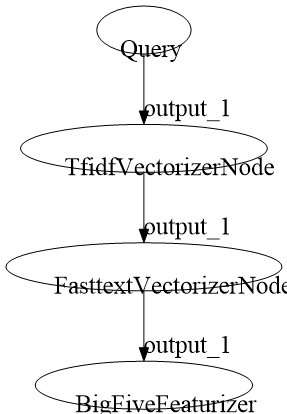

In [96]:
from IPython.display import Image
p_embeddings.draw()
# display the saved image in the notebook
Image(filename="pipeline.png")

# Testings

In [97]:
from haystack import BaseComponent
from typing import Optional, List

class CustomComponent(BaseComponent):
    # Number of outputs. >1 only required, if we have a decision node
    outgoing_edges = 1

    def run(self, query: str, my_optional_param: Optional[int]):
        # process the inputs
        output = {"my_output": "out1"}
        return output, "output_1"

    def run_batch(self, queries: List[str], my_optional_param: Optional[int]):
        # process the inputs
        output = {"my_output": "out1"}
        return output, "output_1"

component = CustomComponent()

pipeline = Pipeline()
#pipeline.add_node(component, name="custom_component", requires=["text"], produces=["custom_features"])
pipeline.add_node(component, name="custom_component", inputs=["text"])

# You can then execute the pipeline on input text as follows:
result = pipeline.run(query="My input text to process with custom component")

PipelineConfigError: The first node of a pipeline must have one single root node as input (Query or File).